## Setup

In [636]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import os;

# os.environ["ACCELERATE_DISABLE_RICH"] = "1"

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import sys
from functools import partial
import json
from typing import List, Tuple, Union, Optional, Callable, Dict
import torch as t
from torch import Tensor
from sklearn.linear_model import LinearRegression
import numpy as np
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import einops
from tqdm import tqdm
from jaxtyping import Float, Int, Bool
from pathlib import Path
import pandas as pd
import circuitsvis as cv
import webbrowser
from IPython.display import display
from transformer_lens import utils, ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint
from transformer_lens.components import LayerNorm
from eindex import eindex

# t.set_grad_enabled(False)

# Make sure exercises are in the path
chapter = r"chapter1_transformers"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "monthly_algorithmic_problems" / "october23_sorted_list"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from monthly_algorithmic_problems.october23_sorted_list.model import create_model
from monthly_algorithmic_problems.october23_sorted_list.training import train, TrainArgs
from monthly_algorithmic_problems.october23_sorted_list.dataset import SortedListDataset
from plotly_utils import hist, bar, imshow

device = t.device("cpu")

MAIN = __name__ == "__main__"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [637]:
dataset = SortedListDataset(size=10, list_len=5, max_value=15, seed=43)

print("Sequence = ", dataset[0])
print("Str toks = ", dataset.str_toks[0])

Sequence =  tensor([ 7,  5, 11,  4,  1, 16,  1,  4,  5,  7, 11])
Str toks =  ['7', '5', '11', '4', '1', 'SEP', '1', '4', '5', '7', '11']


## Transformer

In [638]:
# 1-layer transformer, 3 heads, no MLP

args = TrainArgs(
    list_len=10,
    max_value=50,
    trainset_size=150_000,
    valset_size=10_000,
    epochs=25,
    batch_size=512,
    lr_start=1e-3,
    lr_end=1e-4,
    weight_decay=0.005,
    seed=42,
    d_model=96,
    d_head=48,
    n_layers=1,
    n_heads=2,
    d_mlp=None,
    normalization_type="LN",
    use_wandb=False,
    device=device,
)
# model = train(args)

In [639]:
# Save the model
filename = section_dir / "AF_sorted_list_model.pt"
# t.save(model.state_dict(), filename)

# Check we can load in the model
model = create_model(
    list_len=10,
    max_value=50,
    seed=0,
    d_model=96,
    d_head=48,
    n_layers=1,
    n_heads=2,
    normalization_type="LN",
    d_mlp=None
)
model.load_state_dict(t.load(filename))

<All keys matched successfully>

In [640]:
dataset = SortedListDataset(size=500, list_len=10, max_value=50, seed=43)

logits, cache = model.run_with_cache(dataset.toks)
logits: Tensor = logits[:, dataset.list_len:-1, :]

targets = dataset.toks[:, dataset.list_len+1:]

logprobs = logits.log_softmax(-1) # [batch seq_len vocab_out]
probs = logprobs.softmax(-1)

batch_size, seq_len = dataset.toks.shape
logprobs_correct = eindex(logprobs, targets, "batch seq [batch seq]")
probs_correct = eindex(probs, targets, "batch seq [batch seq]")

avg_cross_entropy_loss = -logprobs_correct.mean().item()

print(f"Average cross entropy loss: {avg_cross_entropy_loss:.3f}")
print(f"Mean probability on correct label: {probs_correct.mean():.3f}")
print(f"Median probability on correct label: {probs_correct.median():.3f}")
print(f"Min probability on correct label: {probs_correct.min():.3f}")

# cv.attention.from_cache(
#     cache = cache,
#     tokens = dataset.str_toks,
#     batch_idx = list(range(10)),
#     radioitems = True,
#     return_mode = "view",
#     batch_labels = [" ".join(s) for s in dataset.str_toks],
#     mode = "small",
# )

Average cross entropy loss: 0.039
Mean probability on correct label: 0.966
Median probability on correct label: 0.981
Min probability on correct label: 0.001


In [641]:
#print(dataset.str_toks[0])

seq = lambda x,l : [i for i in range(x+l-1,x-1,-1)]  + [ 51 ] + [ i for i in range(x,x+l) ]
ds = [ seq(x,10) for x in range(37,42,1) ]
ds = t.tensor(ds)
list_len = int( (ds.size(-1)-1 ) / 2 ) 


ds[:,list_len-1] = 0
ds[:,list_len+1] = 0
print(ds)
seq_len  = ds.size(-1)

# ds = dataset.toks[:10]

logits, cache = model.run_with_cache(ds)
logits: Tensor = logits[:, list_len:-1, :]
targets = ds[:, list_len+1:]
logprobs = logits.log_softmax(-1) # [batch seq_len vocab_out]
probs = logprobs.softmax(-1)

# 
print(ds.shape)
print(cache["pattern",0].shape)
print(probs.shape)

tensor([[46, 45, 44, 43, 42, 41, 40, 39, 38,  0, 51,  0, 38, 39, 40, 41, 42, 43,
         44, 45, 46],
        [47, 46, 45, 44, 43, 42, 41, 40, 39,  0, 51,  0, 39, 40, 41, 42, 43, 44,
         45, 46, 47],
        [48, 47, 46, 45, 44, 43, 42, 41, 40,  0, 51,  0, 40, 41, 42, 43, 44, 45,
         46, 47, 48],
        [49, 48, 47, 46, 45, 44, 43, 42, 41,  0, 51,  0, 41, 42, 43, 44, 45, 46,
         47, 48, 49],
        [50, 49, 48, 47, 46, 45, 44, 43, 42,  0, 51,  0, 42, 43, 44, 45, 46, 47,
         48, 49, 50]])
torch.Size([5, 21])
torch.Size([5, 2, 21, 21])
torch.Size([5, 10, 52])


In [642]:
def show(ds,probs):


    list_len = int( (ds.size(-1)-1 ) / 2 ) 
    seq_len  = ds.size(-1)

    # print("list_len",list_len)
    # print("seq_len",seq_len)

    #  tokens shape torch.Size([1, 103])
    # probs shape torch.Size([1, 103, 52])
    # list_len 51
    # seq_len 103
    # len x 51
    # probs.T shape torch.Size([52, 103])


    strs = [ str(i.item()) for i in ds[:list_len] ] 
    x    = [ ds[j] for j in range( list_len+1, seq_len) ]

    indices = t.argmax(probs.T,dim=0)
    # print(probs.T.shape)
    # print(indices)

    chf = lambda s,t,i : "〇" if (s==t and t==i) else "●" if (s==t) else "○" if (s==i) else " "


    text = [[ chf( str(str_tok),str(target.item()),str(indices[t].item())) for t,target in enumerate(ds[list_len+1:seq_len])]
            for str_tok in dataset.vocab]

    # print("len x",len(x))
    # print("probs.T shape",probs.T.shape)

    imshow(
        probs.T,
        y=dataset.vocab,
        # x=x,
        labels={"x": "Token", "y": "Vocab"},
        xaxis_tickangle=0,
        title=f"Sample model probabilities:<br>Unsorted = ({','.join( strs ) })",
        text=text,
        range_color=[0, 1],
        color_continuous_scale=["white",  "blue"],
        width=800,
        height=1000,
    )

# show(ds[0],probs[0])
# show(ds[1],probs[1])
# show(ds[2],probs[2])
for i in range(ds.size(0)):
    show(ds[i],probs[i])




In [643]:
def apply_causal_mask(
    attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
    '''
    Applies a causal mask to attention scores, and returns masked scores.
    '''
    all_ones = t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
    mask = t.triu(all_ones, diagonal=1).bool()
    attn_scores.masked_fill_(mask, model.IGNORE)
    return attn_scores

model.register_buffer("IGNORE", t.tensor(-1e5, dtype=t.float32, device=device))

total_tokens   = 51
model_list_len = 10
start_pos = total_tokens-model_list_len

tokens = t.tensor([seq(0,total_tokens)]) #51
list_len  = int( (tokens.size(-1)-1 ) / 2 ) 

# print("tokens",tokens.shape)
# print("tokens",tokens)
resid_pre_o = model.embed.W_E[tokens]

pos_embed     = t.zeros_like(resid_pre)
pos_embed_mod = model.pos_embed(tokens)

finish_pos = start_pos + pos_embed_mod.size(1)
pos_embed[:,start_pos : finish_pos, : ] = pos_embed_mod


# assignment torch.Size([1, 41, 96])
# non-repeated torch.Size([21, 96])
# print( "assignment", pos_embed[:, 0 : start_pos, : ].shape )
# print( "non-repeated", pos_embed_mod[:,0,:].shape )
# print( "repeated",     pos_embed_mod[:,0,:].unsqueeze(0).expand(-1,start_pos,-1).shape )

if (start_pos>0) : #0,-1
    pos_embed[:, 0 : start_pos, : ] = pos_embed_mod[:,0,:].unsqueeze(1).expand(-1,start_pos,-1)
    pos_embed[:, finish_pos:  , : ] = pos_embed_mod[:,-1,:].unsqueeze(1).expand(-1,start_pos,-1)

resid_pre = resid_pre_o + pos_embed

t.set_printoptions(precision=2,sci_mode=False)
# print("pos_embed_mod:",pos_embed_mod.shape)
# print("pos embed by seq" , t.sum( t.abs(pos_embed_mod).squeeze(0), dim=1))

# reside-pre torch.Size([1, 21, 96])
# pos_embed torch.Size([1, 21, 96])


 #+ model.pos_embed(tokens)

# print( "resid_pre", resid_pre.shape)
# print( "pos_embed", model.pos_embed(tokens).shape)



# print('resid_pre', t.sum( resid_pre - cache["resid_pre",0][0,:] ) )

normalized = model.blocks[0].ln1(resid_pre) 

normalized2 = model.blocks[0].ln1(resid_pre_o)

# print('normalized', t.sum( normalized - cache["normalized",0][0,:] ) )

q = einops.einsum(
            normalized, model.W_Q[0],
            "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head",
        ) + model.b_Q[0]

# print("q comp", t.sum( q - cache["q",0][0,:] ) )


k = einops.einsum(
    normalized, model.W_K[0],
    "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head",
) + model.b_K[0]

# print("k comp", t.sum( k - cache["k",0][0,:] ) )


v = einops.einsum(
    normalized, model.W_V[0],
    "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head",
) + model.b_V[0]

attn_scores = einops.einsum(
    q, k,
    "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K",
)
attn_scores_masked = apply_causal_mask(attn_scores / model.cfg.d_head ** 0.5)
attn_pattern = attn_scores_masked.softmax(-1)


z = einops.einsum(
    v, attn_pattern,
    "batch posn_K nheads d_head, batch nheads posn_Q posn_K -> batch posn_Q nheads d_head",
)

# Calculate output (by applying matrix W_O and summing over heads, then adding bias b_O)
attn_out = einops.einsum(
    z, model.W_O[0],
    "batch posn_Q nheads d_head, nheads d_head d_model -> batch posn_Q d_model",
) + model.b_O[0]

resid_post = attn_out + resid_pre

# print("resid_post", t.sum( resid_post - cache["resid_post",0][0,:] ) )

final_embedding = model.ln_final(resid_post)
logits = model.unembed(final_embedding)


logits = logits[:, list_len:-1, :]
logprobs = logits.log_softmax(-1) # [batch seq_len vocab_out]
token_probs = logprobs.softmax(-1)

show(tokens[0],token_probs[0])

torch.Size([52, 52])


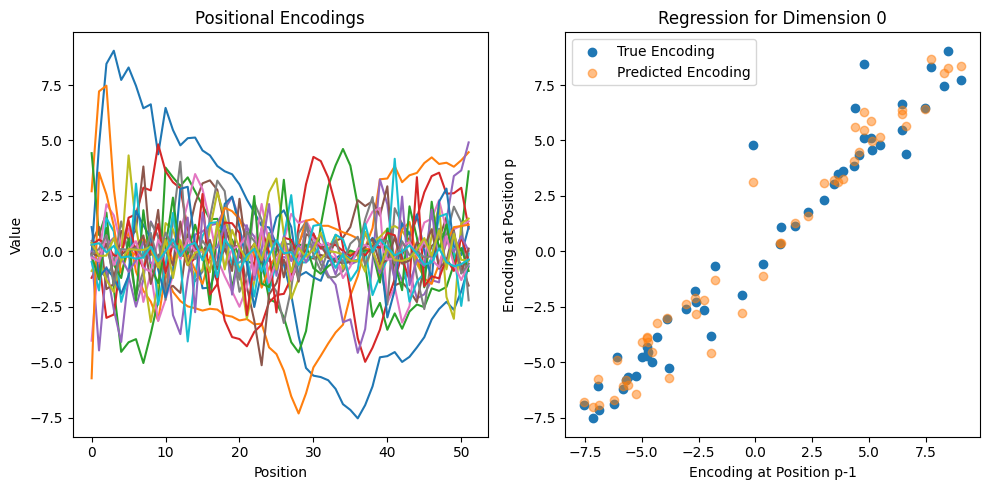

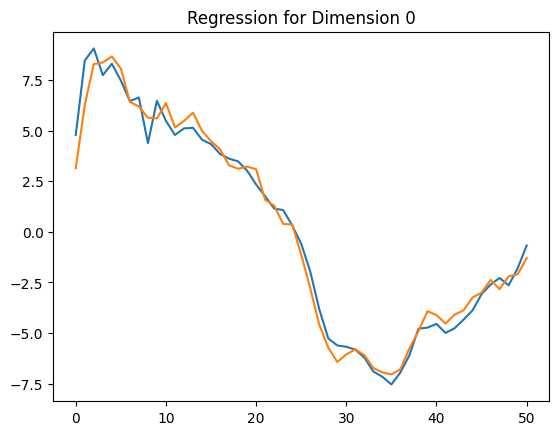

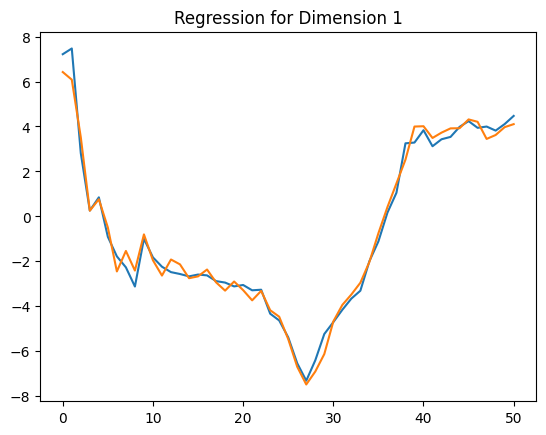

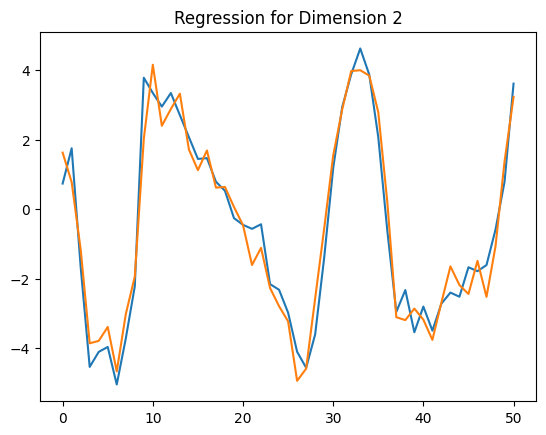

R^2 for dimension 0: 0.96
R^2 for dimension 1: 0.90
R^2 for dimension 2: 0.68
R^2 for dimension 3: 0.83
R^2 for dimension 4: 0.45
R^2 for dimension 5: 0.27
R^2 for dimension 6: 0.25
R^2 for dimension 7: -0.47
R^2 for dimension 8: -0.33
R^2 for dimension 9: -0.93
R^2 for dimension 10: -0.16
R^2 for dimension 11: -2.46
R^2 for dimension 12: -1.91
R^2 for dimension 13: -1.87
R^2 for dimension 14: -2.69
R^2 for dimension 15: -4.03
(20, 20)
(20,)
[[ 9.72564280e-01  1.63564712e-01  9.65092257e-02  4.22622403e-03
  -6.53537735e-02  1.27952039e-01 -1.62716061e-01  1.26228929e-01
  -5.33278324e-02 -2.72869974e-01 -2.71651195e-03 -2.15129107e-01
  -1.14070609e-01  1.07760504e-01  1.09208655e-02  2.23630935e-01
   1.93150476e-01 -5.04442900e-02  6.22882023e-02  1.94323748e-01]
 [-1.20416172e-01  9.47424948e-01  5.01832403e-02  3.68754305e-02
  -3.38283181e-02  2.36997500e-01 -2.48944670e-01  1.84385613e-01
  -9.94244441e-02 -2.76709318e-01  1.30969239e-02 -3.66294175e-01
  -1.35529995e-01  7.9850

In [644]:

import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

embedding = normalized


st = int( (embedding.shape[1] -1) / 2 )
reshaped_embedding = embedding[:,st:,:].squeeze(0)

# Compute the SVD
U, S, V = t.svd(reshaped_embedding)

# Project the data onto the first two principal components
projection = reshaped_embedding @ V[:, :20]

# Convert the projection to a Pandas DataFrame for easy plotting
import pandas as pd
pdf = pd.DataFrame(projection.detach().cpu().numpy(), columns=[ 'PC'+str(i+1) for i in range(20)])

# Create a scatter plot of the projection onto the first two principal components
token_labels = [i for i in range(0, pdf.shape[0] )]


# fig =go.Figure( data=[go.Scatter3d( x=pdf['PC1'], y=pdf['PC2'], z=pdf['PC3'], text=token_labels)])
# fig = px.scatter(x=np.arange(0,pdf['PC3'].shape[0]), y=pdf['PC3'], text=token_labels)
fig = px.scatter(x=pdf['PC1'], y=pdf['PC2'], text=token_labels)
fig.update_layout(
    title='Projections of Original Embeddings onto 2 Principal Components',
    width=600,
    height=600,
)


fig.show()

variance_explained = S ** 2 / (S ** 2).sum()

# Convert to percentage
variance_explained_percentage = variance_explained * 100

# Create a bar chart
fig = go.Figure(
    data=[
        go.Bar(
            x=[f'PC{i+1}' for i in range(len(variance_explained))],
            y=variance_explained_percentage.tolist(),
        )
    ],
    layout=go.Layout(
        title='Variance Explained by Principal Components',
        xaxis_title='Principal Component',
        yaxis_title='Variance Explained (%)',
    )
)

fig.show()

# Project the data onto all of the principal components
Y = reshaped_embedding @ V

print(Y.shape)

Y = Y[:,:20]



# Y now has shape [103, 96] and contains the projection of each original embedding
# onto all of the principal components

# Create a heatmap to visualize the projections
fig = go.Figure(data=go.Heatmap(
    z= Y.t().detach().cpu().numpy(),
    colorscale='Viridis',
    x=list(range(1, 104)),  # Assuming the tokens are numbered from 1 to 103
    y=[f'PC{i+1}' for i in range(Y.size(1))],
))

fig.update_layout(
    title='Projections of Original Embeddings onto All Principal Components',
    xaxis_title='Token',
    yaxis_title='Principal Component',
)

fig.show()


proj = projection.detach().cpu().numpy()

# Prepare data for regression
X = proj[:-1]  # encodings at position p-1
y = proj[1:]   # encodings at position p

# Fit linear regression
lr = LinearRegression()
lr.fit(X, y)

# Predict
y_pred = lr.predict(X)

# Visualize the positional encodings
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(proj)
plt.title('Positional Encodings')
plt.xlabel('Position')
plt.ylabel('Value')

# Visualize the regression results for a single dimension
# Choose a dimension to visualize
dim = 0
plt.subplot(1, 2, 2)
plt.scatter(X[:, dim], y[:, dim], label='True Encoding')
plt.scatter(X[:, dim], y_pred[:, dim], label='Predicted Encoding', alpha=0.5)
plt.title(f'Regression for Dimension {dim}')
plt.xlabel('Encoding at Position p-1')
plt.ylabel('Encoding at Position p')
plt.legend()

plt.tight_layout()
plt.show()
plt.title(f'Regression for Dimension {0}')
plt.plot(y[:, 0], label='True Encoding')
plt.plot(y_pred[:, 0], label='Predicted Encoding')
plt.show()
plt.title(f'Regression for Dimension {1}')
plt.plot(y[:, 1], label='True Encoding')
plt.plot(y_pred[:, 1], label='Predicted Encoding')
plt.show()
plt.title(f'Regression for Dimension {2}')
plt.plot(y[:, 2], label='True Encoding')
plt.plot(y_pred[:, 2], label='Predicted Encoding')
plt.show()
# Initialize an array to hold the R^2 values
r2_values = np.empty(16)

# Loop through each dimension
for i in range(16):
    r2_values[i] = r2_score(y_pred[:, i], X[:, i])

# Print out the R^2 values
for i, r2 in enumerate(r2_values):
    print(f'R^2 for dimension {i}: {r2:.2f}')

coefficients = lr.coef_
intercept = lr.intercept_
print(coefficients.shape)
print(intercept.shape)
print(coefficients)
print(intercept)







In [645]:
!pip install dash

In [652]:
import torch
import plotly.graph_objects as go
from sklearn.metrics.pairwise import cosine_similarity
import dash
from dash import dcc, html


# Assume final_embedding is your tensor
# embedding = q.reshape(q.shape[0], q.shape[1], -1)
embedding = normalized


st = int( (embedding.shape[1] -1) / 2 + 1)

print("tokens", tokens.shape )
print("tokens", tokens[:,st:])


reshaped_embedding = embedding[:,:,:].squeeze(0)


# # Compute the Gram matrix
# gram_matrix = torch.mm(normalized_embedding, normalized_embedding.t())

reshaped_embeddings_p = reshaped_embedding[2:]
reshaped_embeddings_p_minus_1 = reshaped_embedding[:-2]

# Compute the Gram matrix
gram_matrix = torch.mm(reshaped_embeddings_p, reshaped_embeddings_p_minus_1.t())

print("gram_matrix", gram_matrix.shape)

gram_matrix2 = gram_matrix.unsqueeze(0).unsqueeze(0)

print("gram_matrix2", gram_matrix2.shape)
# attn_scores = einops.einsum(
#     q, k,
#     "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K",
# )
gram_matrix_masked = apply_causal_mask( gram_matrix2 / model.cfg.d_head ** 0.5)


print("gram_matrix_masked", gram_matrix_masked.shape)

gram_pattern = gram_matrix_masked.softmax(-1)

print("gram_pattern", gram_pattern.shape)

gram_matrix = gram_pattern.squeeze(0).squeeze(0)


print("gram_matrix", gram_matrix.shape)


# Convert the tensor to a numpy array and compute the cosine similarity matrix
# cosine_similarity_matrix_np = cosine_similarity(reshaped_embedding.cpu().detach().numpy())

# # Optionally, convert the cosine similarity matrix back to a tensor
# cosine_similarity_matrix = torch.tensor(cosine_similarity_matrix_np)

# gram_matrix = cosine_similarity_matrix
colorscale = [[0, 'red'], [0.01, 'white'], [1, 'blue']]

fig = go.Figure(data=go.Contour(
    z=t.log(gram_matrix).detach().cpu().numpy(),
    colorscale='Viridis',
    contours=dict(
            start=-12,
            end=0,
            size=1,
        ),
    x=list(range(1, gram_matrix.size(-1))),  # Assuming the tokens are numbered from 1 to 103
    y=list(range(1, gram_matrix.size(-1))),
))


fig.update_layout(
    title='Normalized Gram Matrix of Embeddings',
    xaxis_title='Token',
    yaxis_title='Token',
    yaxis_autorange='reversed',  # This will reverse the order of the Y-axis
    autosize=False,
    height=1000,
    width=1000,
)

# fig.show()



app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='contour-plot',
              figure=fig),
    dcc.Slider(id='y-slider',
               min=1,
               max=gram_matrix.size(-1),
               value=1,  # Set initial value to the middle of the range
               marks={str(i): str(i) for i in range(1, gram_matrix.size(-1))}),
    dcc.Graph(id='cross-section-plot')
])

@app.callback(
    dash.dependencies.Output('cross-section-plot', 'figure'),
    [dash.dependencies.Input('y-slider', 'value')]
)
def update_cross_section(y_value):
    z_cross_section = t.log(gram_matrix[ int(y_value) - 1, :]).detach().cpu().numpy()
    fig_cross_section = go.Figure(data=go.Scatter(
        x=list(range(1, gram_matrix.size(-1))),
        y=z_cross_section,
        mode='lines'
    ))
    fig_cross_section.update_layout(
        title=f'Cross Section at y = {y_value}',
        xaxis_title='Token',
        yaxis_title='Value',

    )
    return fig_cross_section

if __name__ == '__main__':
    app.run_server(debug=True)




tokens torch.Size([1, 103])
tokens tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]])
gram_matrix torch.Size([101, 101])
gram_matrix2 torch.Size([1, 1, 101, 101])
gram_matrix_masked torch.Size([1, 1, 101, 101])
gram_pattern torch.Size([1, 1, 101, 101])
gram_matrix torch.Size([101, 101])


In [647]:
import plotly.subplots as sp
import plotly.graph_objects as go


def visualize(attention_matrix,labels_tensor) :

    pi = lambda i,j : l[j] if ( i==(len(l)-1)/2 ) else " "
    pj = lambda i,j : l[i] if ( j==(len(l)-1)/2 ) else " "
    p  = lambda i,j : pi(i,j) + " " + pj(i,j)

    xlim = int( (attention_matrix.shape[2]-1)/2)
    ylim = attention_matrix.shape[3]

    i = 0
    for calc_idx in range( attention_matrix.shape[0] ):
        for head_idx in range( attention_matrix.shape[1]):
            am = attention_matrix[calc_idx, head_idx,:,:]
            am = t.flip(am, [0])

            i = i + 1
            l = labels_tensor[calc_idx,:].detach().cpu().numpy().astype(str).tolist()
            text = [ [ p(i,j) for i in range(len(l)) ] for j in range(len(l))   ]

            indices = t.argmax(am, dim=-1)
            indices = indices.cpu().numpy().tolist()

            for idx,i in enumerate(range(len(indices)-1,-1,-1)):
                text[i][indices[i]] = "〇"

            fig = go.Figure(data=go.Contour(
                z = t.log(am).detach().cpu().numpy(),
                text = text,
                texttemplate="%{text}",
                colorscale='Viridis',
                colorbar=dict(len=0.2, y=(calc_idx + 0.5) / 5),
                textfont={"size":8},
                showscale=True,
                contours=dict(
                    start=-12,
                    end=0,
                    size=1,
                ),
            ))
            
            # fig.add_trace(heatmap, row=i , col= 1)
            # fig.update_yaxes(visible=False, showticklabels=False)
            # fig.update_xaxes(visible=False, showticklabels=False)
            # Update layout for better readability
            fig.update_layout(
                height=1000,
                width=1000,
                title_text= f'Layer {calc_idx}, Head {head_idx}',
                showlegend=True,
                # yaxis_autorange='reversed', 
            )
            fig.show() #UNCOMMENT TO SHOW EACH HEATMAP

#visualize( cache["pattern",0],ds)
visualize( attn_pattern,tokens)

In [653]:
# Function to create positional encodings
def get_positional_encodings(seq_len, d_model):
    pos_encodings = np.zeros((seq_len, d_model))
    for pos in range(seq_len):
        for i in range(0, d_model, 2):
            pos_encodings[pos, i] = np.sin(pos / np.power(10000, (2 * i) / np.float32(d_model)))
            if i + 1 < d_model:  # guard index out of range
                pos_encodings[pos, i + 1] = np.cos(pos / np.power(10000, (2 * i) / np.float32(d_model)))
    return pos_encodings

# # Generate positional encodings

# Parameters
# seq_len = 100  # length of the sequence
# d_model = 16  # dimensions of the model
# pos_encodings = get_positional_encodings(seq_len, d_model)

# # Prepare data for regression
# print(pos_encodings.shape)

st = int((normalized.shape[1] - 1)/2 + 1)
pos_encodings = normalized[:,st:,:].squeeze(0).detach().cpu().numpy()
print(pos_encodings.shape)
seq_len = pos_encodings.shape[0]
d_model = pos_encodings.shape[1]

(51, 96)


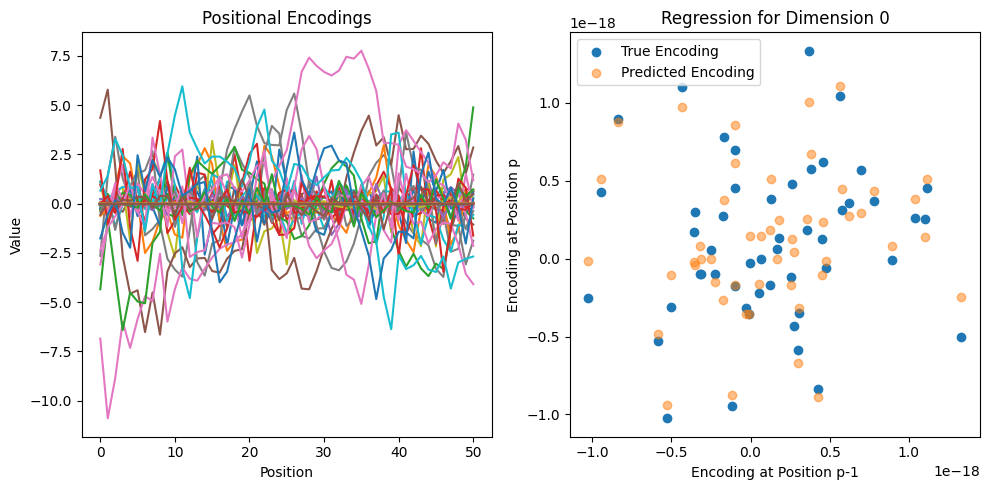

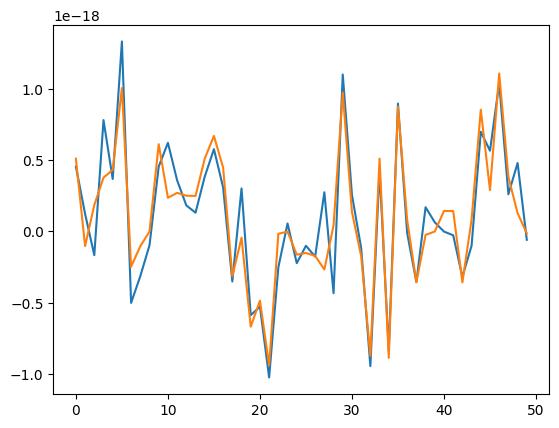

R^2 for dimension 0: -1.043694
R^2 for dimension 1: -1.041088
R^2 for dimension 2: -1.045928
R^2 for dimension 3: -1.559970
R^2 for dimension 4: -1.046480
R^2 for dimension 5: -0.938211
R^2 for dimension 6: -1.045990
R^2 for dimension 7: -1.046423
R^2 for dimension 8: -1.045232
R^2 for dimension 9: -1.681211
R^2 for dimension 10: -1.661224
R^2 for dimension 11: -1.046033
R^2 for dimension 12: -1.042316
R^2 for dimension 13: -1.046317
R^2 for dimension 14: -1.102477
R^2 for dimension 15: -1.044549
(96, 96)
(96,)
[[-8.22743099e-19 -4.02346440e-19  6.88339510e-20 ... -1.42581266e-34
  -1.19196835e-29 -2.85368230e-29]
 [-4.57857095e-16 -2.23906198e-16  3.83060195e-17 ... -7.93465152e-32
  -6.63331103e-27 -1.58807607e-26]
 [-1.31188595e-17 -6.41551771e-18  1.09757313e-18 ... -2.27349460e-33
  -1.90062395e-28 -4.55026901e-28]
 ...
 [-2.14543307e-21 -1.04918076e-21  1.79496300e-22 ... -3.71803001e-37
  -3.10824481e-32 -7.44142349e-32]
 [-1.73746072e-16 -8.49671190e-17  1.45363361e-17 ... -3.0

In [685]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import torch.nn.functional as F

# Prepare data for regression
X = pos_encodings[:-1]  # encodings at position p-1
y = pos_encodings[1:]   # encodings at position p




# Prepare data for regression
X = pos_encodings[:-1]  # encodings at position p-1
y = pos_encodings[1:]   # encodings at position p


# Fit linear regression
lr = LinearRegression()
lr.fit(X, y)

# Predict
y_pred = lr.predict(X)

# Visualize the positional encodings
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(pos_encodings)
plt.title('Positional Encodings')
plt.xlabel('Position')
plt.ylabel('Value')

# Convert y and y_pred to tensors (if they are not already tensors)
y_tensor = t.tensor(y, dtype=t.float32)
y_pred_tensor = t.tensor(y_pred, dtype=t.float32)



# Normalize y and y_pred



y_l2_normalized      = F.normalize(y_tensor, p=2, dim=0)
y_pred_l2_normalized = F.normalize(y_pred_tensor, p=2, dim=0)

gram_matrix = t.mm( y_l2_normalized, y_pred_l2_normalized.t())

# Compute the Gram matrix
# gram_matrix = torch.mm(y_normalized, y_pred_normalized.t())
# gram_matrix = torch.mm(t.tensor(y), t.tensor(y_pred).t())
colorscale = [[0, 'blue'], [.5, 'white'], [1.0, 'green']]
# colorscale = [ [-1.0, 'blue'], [0.0, 'white'], [1.0, 'green']]

fig = go.Figure(data=go.Contour(
    z=gram_matrix.detach().cpu().numpy(),
    colorscale=colorscale,
    zmin=-1,
    zmax=1,
    x=list(range(1, gram_matrix.size(-1))),  # Assuming the tokens are numbered from 1 to 103
    y=list(range(1, gram_matrix.size(-1))),
))


fig.update_layout(
    title='Normalized Gram Matrix of Predicted vs Actual positional erndocings',
    xaxis_title='Actual Token at position p-1',
    yaxis_title='Predicted Token at position p-1 regressed from p',
    yaxis_autorange='reversed',  # This will reverse the order of the Y-axis
    autosize=False,
    height=500,
    width=500,
)
fig.show()
# Visualize the regression results for a single dimension
# Choose a dimension to visualize
dim = 0
plt.subplot(1, 2, 2)
plt.scatter(X[:, dim], y[:, dim], label='True Encoding')
plt.scatter(X[:, dim], y_pred[:, dim], label='Predicted Encoding', alpha=0.5)
plt.title(f'Regression for Dimension {dim}')
plt.xlabel('Encoding at Position p-1')
plt.ylabel('Encoding at Position p')
plt.legend()

plt.tight_layout()
plt.show()

plt.plot(y[:, 0], label='True Encoding')
plt.plot(y_pred[:, 0], label='Predicted Encoding')

plt.show()
# Initialize an array to hold the R^2 values
r2_values = np.empty(16)

# Loop through each dimension
for i in range(16):
    r2_values[i] = r2_score(y_pred[:, i], X[:, i])

# Print out the R^2 values
for i, r2 in enumerate(r2_values):
    print(f'R^2 for dimension {i}: {r2:.6f}')

coefficients = lr.coef_
intercept = lr.intercept_
print(coefficients.shape)
print(intercept.shape)
print(coefficients)
print(intercept)

(100, 16)
(51, 96)
(51, 1)
R-squared: 0.99


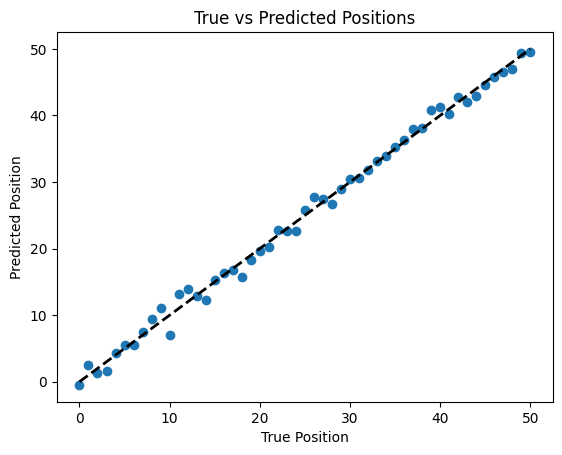

In [650]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt



X = pos_encodings  # features are the values of the positional encodings
y = np.arange(seq_len).reshape(-1, 1)  # target is the position of each encoding
print(y.shape)

# Fit linear regression
lr = LinearRegression()
lr.fit(X, y)

# Predict positions
predicted_positions = lr.predict(X)

# Print out R-squared value
print(f'R-squared: {lr.score(X, y):.2f}')

# Visualize true vs predicted positions
plt.scatter(y, predicted_positions)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Position')
plt.ylabel('Predicted Position')
plt.title('True vs Predicted Positions')
plt.show()


